In [102]:
import jax.numpy as np
import numpy as onp
from functools import partial
from jax import vmap
from jax.lax import scan
from jax.lax import cond
from jax import random
from jax import jit
from jax import jacrev, jacfwd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import manifold, datasets
from jax import make_jaxpr
from jax import grad

from jax.config import config
config.update("jax_debug_nans", True)

In [2]:
def pca(X: np.ndarray, no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """
    print("Preprocessing the data using PCA...")
    #(n, d) = X.shape
    X = X - np.mean(X, axis=0)
    u, s, vh = np.linalg.svd(X, full_matrices=False, compute_uv=True, hermitian=False)
    #l = (s ** 2 / (d))[0:no_dims]
    M = vh[0:no_dims, :]
    Y = np.dot(X, M.T)
    return Y

def Hbeta(D: np.ndarray, beta=1.0):
    """
    Compute the log2(perplexity)=Entropy and the P-row (P_i) for a specific value of the
        precision=1/(sigma**2) (beta) of a Gaussian distribution. D: vector of squared Euclidean distances (without i)
    :param D: vector of length d, squared Euclidean distances to all other datapoints (except itself)
    :param beta: precision = beta = 1/sigma**2
    :return: H: log2(Entropy), P: computed probabilites
    """
    P = np.exp(-D * beta)     # numerator of p j|i
    sumP = np.sum(P, axis=None)    # denominator of p j|i --> normalization factor
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

def HdiffGreaterTrue(*betas):
    beta, betamax = betas
    return beta*2

def HdiffGreaterFalse(*betas):
    beta, betamax = betas
    return (beta+betamax)/2

def HdiffSmallerTrue(*betas):
    beta, betamin = betas
    return beta/2

def HdiffSmallerFalse(*betas):
    beta, betamin = betas
    return (beta+betamin)/2

def HdiffGreater(*betas):
    beta, betamin, betamax = betas
    betamin = beta
    beta = cond((np.logical_or(betamax == np.inf, betamax == -np.inf)), HdiffGreaterTrue, HdiffGreaterFalse, *(beta, betamax))
    return beta, betamin, betamax

def HdiffSmaller(*betas):
    beta, betamin, betamax = betas
    betamax = beta
    beta = cond(np.logical_or(betamin == np.inf, betamin == -np.inf), HdiffSmallerTrue, HdiffSmallerFalse, *(beta, betamin))
    return beta, betamin, betamax

def HdiffGreaterTolerance(*betas):
    beta, betamin, betamax, Hdiff = betas
    beta, betamin, betamax = cond(Hdiff > 0, HdiffGreater, HdiffSmaller, *(beta, betamin, betamax))
    return beta, betamin, betamax, Hdiff

def binarySearch(res, el, Di, logU):
    print('Entered binary search function')
    Hdiff, thisP, beta, betamin, betamax = res
    Hdiffbool = np.abs(Hdiff) < 1e-5
    beta, betamin, betamax, Hdiff = cond(np.abs(Hdiff) < 1e-5, lambda a, b, c, d: (a, b, c, d), HdiffGreaterTolerance, *(beta, betamin, betamax, Hdiff))

    (H, thisP) = Hbeta(Di, beta)
    Hdiff = H - logU
    return (Hdiff, thisP, beta, betamin, betamax), el

def x2p_inner(Di: np.ndarray, iterator, beta, betamin, betamax, perplexity=30, tol=1e-5):
    """
    binary search for precision for Pi such that it matches the perplexity defined by the user
    :param Di: vector of length d-1, squared Euclidean distances to all other datapoints (except itself)
    :param beta: precision = beta = 1/sigma**2
    :return: final probabilites p j|i
    """
    # Compute the Gaussian kernel and entropy for the current precision
    logU = np.log(perplexity)
    H, thisP = Hbeta(Di, beta)
    Hdiff = H - logU



    print('Starting binary search')
    #Hdiff, thisP, beta, betamin, betamax = binarySearch((Hdiff, None, beta, betamin, betamax), None, Di, logU)
    binarySearch_func = partial(binarySearch, Di=Di, logU=logU)

    #for i in range(20):
    #    (Hdiff, thisP, beta, betamin, betamax), el = binarySearch_func((Hdiff, thisP, beta, betamin, betamax), (Hdiff, thisP, beta, betamin, betamax))


    # Note: the following binary Search for suitable precisions (betas) will be repeated 50 times and does not include the threshold value
    (Hdiff, thisP, beta, betamin, betamax), el = scan(binarySearch_func, init=(Hdiff, thisP, beta, betamin, betamax), xs=None, length=50)    # Set the final row of P
    thisP = np.insert(thisP, iterator, 0)
    return thisP

def x2p(X: np.ndarray, tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values (high-dim space) in such a way that each
        conditional Gaussian has the same perplexity.
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    D = np.reshape(np.delete(D, np.array([i for i in range(0, D.shape[0]**2, (D.shape[0]+1))])), (n , n - 1 ))
    beta = np.ones(n)      # precisions (1/sigma**2)
    betamin = np.full(n, -np.inf)
    betamax = np.full(n, np.inf)
    P = vmap(partial(x2p_inner, perplexity=perplexity, tol=tol))(D, np.arange(n), beta=beta, betamin=betamin, betamax=betamax)
    return P


def optimizeY(res, el, P, initial_momentum=0.5, final_momentum=0.8, eta=500, min_gain=0.01):
    Y, iY, gains, i = res
    n, d = Y.shape

    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)  # numerator
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    num = num.at[np.diag_indices_from(num)].set(0.)     # numerator
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)


    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = Y_diffs * num_exp
    grad = np.sum((PQ_exp * Y_diffs_wt), axis=1) # Nx2

    # Update Y
    momentum = cond(i<20, lambda: initial_momentum, lambda: final_momentum)
    # this business with "gains" is the bar-delta-bar heuristic to accelerate gradient descent
    # code could be simplified by just omitting it
    # inc = iY * grad > 0
    # dec = iY * grad < 0
    # gains = np.where((iY * grad > 0), gains+0.2, gains)
    # gains = np.where((iY * grad < 0), gains*0.8, gains)
    gains = np.clip(gains, min_gain, np.inf)

    iY = momentum * iY - eta * (gains * grad)
    Y = Y + iY

    Y = Y - np.mean(Y, axis=0)
    P = cond(i==100, lambda x: x/4., lambda x:x, P)
    i += 1
    return ((Y, iY, gains, i), 1.0)


def tsne(X: np.ndarray, no_dims=2, initial_dims=50, perplexity=30.0, learning_rate=500, max_iter = 1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    X = pca(X, initial_dims)
    (n, d) = X.shape
    key = random.PRNGKey(42)

    initial_momentum = 0.5
    final_momentum = 0.8
    eta = learning_rate   # Initial learning rate
    min_gain = 0.01
    # Initialize solution
    Y = random.normal(key, shape=(n, no_dims))
    dY = np.zeros((n, no_dims))
    #Y_t1 = np.zeros((n, no_dims))
    #Y_t2 = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)    # I don't know if the computed P is correct np.sum(P, axis=0) is not 1 everywhere
    P = (P + np.transpose(P))

    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = P * 4.  # early exaggeration
    P = np.maximum(P, 1e-12)

    # for debugging
    #for i in range(1000):
    #  ((P, Y, dY, iY, gains, i), j) = optimizeY((P, Y, dY, iY, gains, i), el=1, initial_momentum = initial_momentum, final_momentum = final_momentum, eta = eta, min_gain = min_gain)

    n, d = Y.shape

    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)  # numerator
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    num = num.at[np.diag_indices_from(num)].set(0.)  # numerator
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)

    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)  # NxNx1
    Y_diffs_wt = Y_diffs * num_exp
    grad = np.sum((PQ_exp * Y_diffs_wt), axis=1)  # Nx2

    # Update Y
    momentum = initial_momentum
    gains = np.clip(gains, min_gain, np.inf)

    iY = momentum * iY - eta * (gains * grad)
    Y = Y + iY

    Y = Y - np.mean(Y, axis=0)

    # jit-compiled version
    #optimizeY_func = partial(optimizeY, P=P, initial_momentum = initial_momentum, final_momentum = final_momentum, eta = eta, min_gain = min_gain)
    # ((Y, iY, gains, i), el) = scan(optimizeY_func, init=(Y, iY, gains, 0), xs=None, length=max_iter)  # Set the final row of P
    return Y


In [107]:
def tsneP(X: np.ndarray, no_dims=2, initial_dims=50, perplexity=30.0, learning_rate=500, max_iter = 1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """
    
    (n, d) = X.shape
    key = random.PRNGKey(42)  
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = learning_rate   # Initial learning rate
    min_gain = 0.01
    # Initialize solution
    Y = random.normal(key, shape=(n, no_dims))
    dY = np.zeros((n, no_dims))
    #Y_t1 = np.zeros((n, no_dims))
    #Y_t2 = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))
    
    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1
    
    def computeP(X, perplexity):    
        X = pca(X, initial_dims)
        # Compute P-values
        P = x2p(X, 1e-5, perplexity)    # I don't know if the computed P is correct np.sum(P, axis=0) is not 1 everywhere
        P = (P + np.transpose(P))

        P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
        P = P * 4.  # early exaggeration
        P = np.maximum(P, 1e-12)
        return P
    
    def computeUpdate(P, Y, initial_momentum, gains, iY): 
        n, d = Y.shape

        # Compute pairwise affinities 
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)  # numerator
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num = num.at[np.diag_indices_from(num)].set(0.)  # numerator
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
        Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
        num_exp = np.expand_dims(num, 2)  # NxNx1
        Y_diffs_wt = Y_diffs * num_exp
        grad = np.sum((PQ_exp * Y_diffs_wt), axis=1)  # Nx2

        # Update Y
        momentum = initial_momentum
        gains = np.clip(gains, min_gain, np.inf)

        iY = momentum * iY - eta * (gains * grad)
        Y = Y + iY

        Y = Y - np.mean(Y, axis=0)
        return Y
    
    P = computeP(X, perplexity)
    computeUpdate_func = partial(computeUpdate, Y=Y, initial_momentum=initial_momentum, gains=gains, iY=iY)
    #Y = computeUpdate_func(P)
    jacobian = jacrev(computeUpdate_func)(P)
    #print(make_jaxpr(jacrev(computeUpdate_func))(P))
    return _, jacobian

In [108]:
n, p = (10, 3)
X, y = datasets.make_blobs(n, p, cluster_std=0.1)

In [109]:
tsneP_func = partial(tsneP, no_dims=2, initial_dims=50, perplexity=30.0, learning_rate=400, max_iter = 200)
Y, jacobian = tsneP_func(X)

Preprocessing the data using PCA...
Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot:>

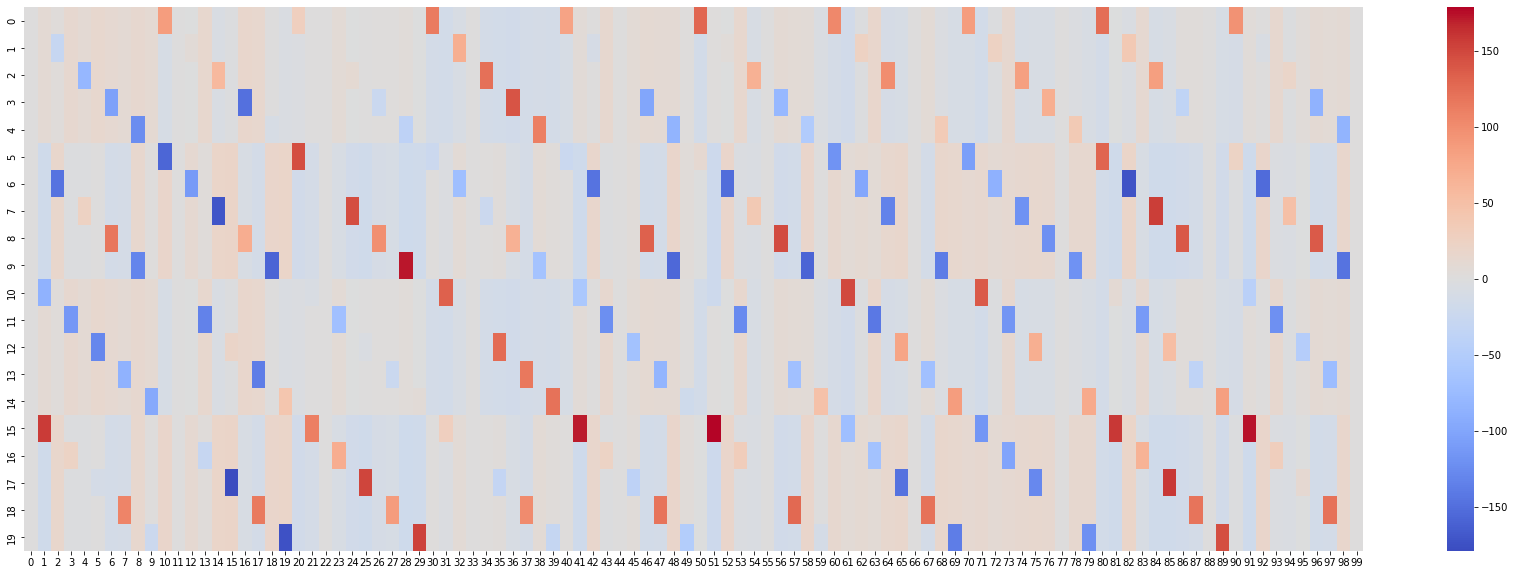

In [111]:
n, p = (n, n)
jacobian_reshape = np.reshape(np.reshape(jacobian, (2, p, n*p), order='F'),
                                        (p*2,
                                        n*p))
f = plt.figure(figsize=(30, 10))
sns.heatmap(jacobian_reshape, cmap="coolwarm")

In [99]:
print(np.shape(jacobian))

(10, 2, 10, 10)
